In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import crflux.models as pm
from MCEq.core import MCEqRun
from scipy.optimize import minimize_scalar


MC_neutrinos_dir = "/groups/icecube/petersen/GraphNetDatabaseRepository/multi_classification_track_cascade_neutrino/using_new_muons_Peter_database/inference/track_cascade_sets/Monte_Carlo_all_events_all_variables.csv"

#Giant neutrino MC db
db_MC_neutrinos = pd.read_csv(MC_neutrinos_dir)


In [2]:
db_MC_neutrinos_cut = db_MC_neutrinos[(db_MC_neutrinos['energy'] > 1)                   #at least 50 GeV (start of data from paper)
                                      & (db_MC_neutrinos['energy'] < 10000)             #at most 10 TeV
                                      & (db_MC_neutrinos['interaction_type'] != -1)     #remove undefined interaction type
                                      & (db_MC_neutrinos['interaction_type'] != 0)]      #remove non-interacting neutrinos
                                      #& (abs(db_MC_neutrinos['pid']) != 16)]            #remove tau neutrinos


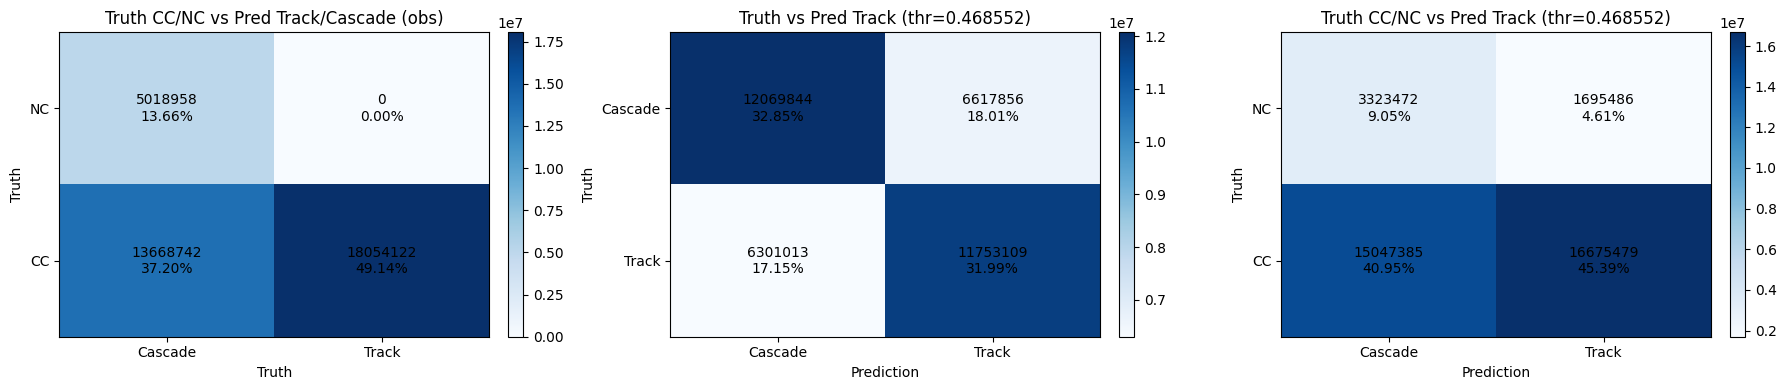

To me, this says that sure if we predict tracklike we can assume its CC, but the opposite is very untrue.


In [32]:
# We cannot measure NC vs CC, we can only say whether it's track-like or cascade-like.
# therefore we make the assumption that a track-like event is a CC muon neutrino, and all cascades are NC. 
# thus ignoring CC electron (and tau) neutrinos.

print("We cannot measure NC vs CC, we can only say whether it's track-like or cascade-like, \ntherefore we make the assumption that a track-like event is a CC muon neutrino, and all cascades are NC, \nthus ignoring CC electron (and tau) neutrinos.")

df = db_MC_neutrinos_cut #for ease of writing
track_cut = 0.46855170500726234 #found above

CC_mask = df['interaction_type'] ==1        #Truth CC
NC_mask = df['interaction_type'] ==2        #Truth NC

track_mu_mask = df['track_mu'] == 1         #Truth tracklike- muon-neutrino
not_track_mu_mask = df['track_mu'] == 0     #Truth cascade-like

TP = int((track_mu_mask & CC_mask).sum())
FP = int((track_mu_mask & NC_mask).sum())
FN = int((not_track_mu_mask & CC_mask).sum())
TN = int((not_track_mu_mask & NC_mask).sum())

# Rows represent Truth [NC, CC] and columns represent Prediction [Cascade, Track]
confusion_df = pd.DataFrame(
    [[TN, FP],
     [FN, TP]],
    index=['NC', 'CC'],
    columns=['Cascade', 'Track']
 )


pred_track_mask = (df['track_mu_pred'] >= track_cut)
true_track_mask = df['track_mu'] == 1
true_casc_mask = df['track_mu'] == 0
TP2 = int((pred_track_mask & true_track_mask).sum())
FP2 = int((pred_track_mask & true_casc_mask).sum())
FN2 = int((~pred_track_mask & true_track_mask).sum())
TN2 = int((~pred_track_mask & true_casc_mask).sum())
confusion_df_pred = pd.DataFrame(
    [[TN2, FP2],
     [FN2, TP2]],
    index=['Cascade', 'Track'],
    columns=['Cascade', 'Track']
)
# Prepare third confusion matrix: Truth interaction_type (NC/CC) vs Predicted track_mu_pred (Cascade/Track)
TP3 = int((pred_track_mask & CC_mask).sum())
FP3 = int((pred_track_mask & NC_mask).sum())
FN3 = int((~pred_track_mask & CC_mask).sum())
TN3 = int((~pred_track_mask & NC_mask).sum())

# Plot all confusion matrices side-by-side
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Left: CC/NC vs Cascade/Track (using observed track_mu)
cm1 = np.array([[TN, FP],
                [FN, TP]])
im1 = axes[0].imshow(cm1, cmap='Blues', aspect='auto')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Cascade', 'Track'])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['NC', 'CC'])
axes[0].set_xlabel('Truth')
axes[0].set_ylabel('Truth')
for i in range(cm1.shape[0]):
    for j in range(cm1.shape[1]):
        count = cm1[i, j]
        pct = count / cm1.sum() if cm1.sum() else 0.0
        axes[0].text(j, i, f"{count}\n{pct:.2%}", ha='center', va='center', color='black')
axes[0].set_title('Truth CC/NC vs Pred Track/Cascade (obs)')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Middle: track_mu (truth) vs track_mu_pred (prediction)
cm2 = np.array([[TN2, FP2],
                [FN2, TP2]])
im2 = axes[1].imshow(cm2, cmap='Blues', aspect='auto')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Cascade', 'Track'])
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Cascade', 'Track'])
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Truth')
for i in range(cm2.shape[0]):
    for j in range(cm2.shape[1]):
        count = cm2[i, j]
        pct = count / cm2.sum() if cm2.sum() else 0.0
        axes[1].text(j, i, f"{count}\n{pct:.2%}", ha='center', va='center', color='black')
axes[1].set_title(f'Truth vs Pred Track (thr={track_cut:g})')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Right: interaction_type (truth NC/CC) vs track_mu_pred (prediction)
cm3 = np.array([[TN3, FP3],
                [FN3, TP3]])
im3 = axes[2].imshow(cm3, cmap='Blues', aspect='auto')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Cascade', 'Track'])
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['NC', 'CC'])
axes[2].set_xlabel('Prediction')
axes[2].set_ylabel('Truth')
for i in range(cm3.shape[0]):
    for j in range(cm3.shape[1]):
        count = cm3[i, j]
        pct = count / cm3.sum() if cm3.sum() else 0.0
        axes[2].text(j, i, f"{count}\n{pct:.2%}", ha='center', va='center', color='black')

axes[2].set_title(f'Truth CC/NC vs Pred Track (thr={track_cut:g})')
plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()

print('To me, this says that sure if we predict tracklike we can assume its CC, but the opposite is very untrue.')

In [33]:
from scipy.optimize import minimize_scalar

def false_from_track_pred(thresh=0.5):
    pred_track_mask = (df['track_mu_pred'] >= thresh)

    CC_mask = df['interaction_type'] ==1
    NC_mask = df['interaction_type'] ==2

    TP = int((pred_track_mask & CC_mask).sum())
    FP = int((pred_track_mask & NC_mask).sum())
    FN = int((~pred_track_mask & CC_mask).sum())
    TN = int((~pred_track_mask & NC_mask).sum())

    wrong_percent = (FP + FN) / (TP + FP + FN + TN) + (abs((FP+TP)-(TN+FN))) / (TP + FP + FN + TN)
    #the above includes both the misclassification rate and the imbalance between predicted classes
    return wrong_percent

false_from_track_pred(thresh=0.46855170500726234)

#result = minimize_scalar(false_from_track_pred, bounds=(0, 1), method='bounded')
#print("Minimum wrong_percent:", result.fun)
#print("Optimal threshold:", result.x)


0.4556926708751678

In [4]:
''' Copied from https://mceq.readthedocs.io/en/latest/examples/Simple_zenith_averaged_neutrinos.html'''

mceq_run = MCEqRun(
#provide the string of the interaction model
interaction_model='SIBYLL2.3c',
#primary cosmic ray flux model 
# 
# (so only cosmic rays? problem?) ^^
#
# support a tuple (primary model class (not instance!), arguments)

primary_model = (pm.HillasGaisser2012, "H3a"),

theta_deg=0.0, #we average so it doesnt matter
)

#Power of energy to scale the flux
mag = 3 #doesnt matter for ratio

#obtain energy grid (fixed) of the solution for the x-axis of the plots
e_grid = mceq_run.e_grid

#Dictionary for results
flux = {}

#Define equidistant grid in cos(theta)
angles = np.arccos(np.linspace(1,0,11))*180./np.pi

#Initialize empty grid
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = np.zeros_like(e_grid)


#Sum fluxes, calculated for different angles
for theta in angles:
    mceq_run.set_theta_deg(theta)
    mceq_run.solve()

    flux['numu_total'] += (mceq_run.get_solution('total_numu', mag)
                          + mceq_run.get_solution('total_antinumu', mag))

    flux['nue_total'] += (mceq_run.get_solution('total_nue', mag)
                         + mceq_run.get_solution('total_antinue', mag))


    # since there are no conventional tau neutrinos, prompt=total
    flux['nutau_total'] += (mceq_run.get_solution('total_nutau', mag)
                        + mceq_run.get_solution('total_antinutau', mag))

log_bincenters = mceq_run.e_grid[(mceq_run.e_grid > 1) & (mceq_run.e_grid < 1e4)]

# log_bins are bin centers, so calculate bin edges for log spacing
log_binedges = np.sqrt(log_bincenters[:-1] * log_bincenters[1:])
log_binedges = np.concatenate(([log_bincenters[0] * (log_bincenters[1]/log_bincenters[0])**-0.5], log_binedges, [log_bincenters[-1] * (log_bincenters[-1]/log_bincenters[-2])**0.5]))  # extrapolate edges

#average the results
for frac in ['numu_total',
             'nue_total','nutau_total']:
    flux[frac] = flux[frac]/float(len(angles))
    flux[frac] = np.array([val for i, val in enumerate(flux[frac]) if e_grid[i] in log_bincenters and val != 0])


MCEqRun::set_interaction_model(): SIBYLL23C
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
ParticleManager::_init_default_tracking(): Initializing default tracking categories (pi, K, mu)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_density_model(): Setting density profile to CORSIKA ('BK_USStd', None)
MCEqRun::set_primary_model(): HillasGaisser2012 H3a
MCEqRun::set_primary_model(): HillasGaisser2012 H3a


In [5]:
print(db_MC_neutrinos_cut.columns)

Index(['track_mu_pred', 'event_no', 'track_mu', 'energy_pred', 'energy',
       'zenith_pred', 'zenith_kappa', 'zenith', 'azimuth_pred',
       'azimuth_kappa', 'azimuth', 'pid_noise_pred', 'pid_muon_pred',
       'pid_neutrino_pred', 'pid', 'pid_neutrino_pred_logit',
       'position_x_pred', 'position_y_pred', 'position_z_pred', 'position_x',
       'position_y', 'position_z', 'N_pulses', 'N_string', 'N_doms',
       'First_dom_time', 'C2HR6', 'CausalVetoHits', 'CleanedFullTimeLength',
       'DCFiducialHits', 'L3_oscNext_bool', 'NAbove200Hits', 'NchCleaned',
       'NoiseEngineNoCharge', 'RTVetoCutHit', 'STW9000_DTW300Hits',
       'UncleanedFullTimeLength', 'VertexGuessZ', 'VetoFiducialRatioHits',
       'interaction_type', 'total_osc_weight'],
      dtype='object')


In [ ]:
true_muon_to_total_list = np.zeros(len(log_bincenters))
true_muon_to_total_weighted_list = np.zeros(len(log_bincenters))

#Unweighted useful totals
NC_list = np.zeros(len(log_bincenters))
CC_list = np.zeros(len(log_bincenters))
track_list = np.zeros(len(log_bincenters))
casc_list = np.zeros(len(log_bincenters))
track_pred_list = np.zeros(len(log_bincenters))
casc_pred_list = np.zeros(len(log_bincenters))

#Weighted versions (per-bin, per-flavor weights from MCEq flux)
NC_w_list = np.zeros(len(log_bincenters))
CC_w_list = np.zeros(len(log_bincenters))
track_w_list = np.zeros(len(log_bincenters))
casc_w_list = np.zeros(len(log_bincenters))
track_pred_w_list = np.zeros(len(log_bincenters))
casc_pred_w_list = np.zeros(len(log_bincenters))

#Weighted energy distribution per flavor (for the right most plot)
mu_hist_w = np.zeros(len(log_bincenters))
e_hist_w = np.zeros(len(log_bincenters))
tau_hist_w = np.zeros(len(log_bincenters))

#Saving the weights
mu_w_list = np.zeros(len(log_bincenters))
e_w_list = np.zeros(len(log_bincenters))
tau_w_list = np.zeros(len(log_bincenters))

force_weights = True

for i in range(len(log_bincenters)):
    # Per-bin flavor weights from MCEq flux, normalized within the bin
    w_mu = float(flux['numu_total'][i]) 
    w_e  = float(flux['nue_total'][i])  
    w_tau= float(flux['nutau_total'][i])
    w_sum = w_mu + w_e + w_tau

    w_mu_n = w_mu / w_sum #normalized weights
    w_e_n  = w_e  / w_sum
    w_tau_n= w_tau / w_sum
    
    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > log_binedges[i]) & (db_MC_neutrinos_cut['energy'] <= log_binedges[i+1])]

    mu_mask  = (abs(db_in_bin['pid']) == 14)
    e_mask   = (abs(db_in_bin['pid']) == 12)
    tau_mask = (abs(db_in_bin['pid']) == 16)

    if force_weights:
        # CSV composition in this bin
        w_from_csv_mu = int(mu_mask.sum())
        w_from_csv_e  = int(e_mask.sum())
        w_from_csv_tau= int(tau_mask.sum())
        
        total_from_csv = w_from_csv_mu + w_from_csv_e + w_from_csv_tau

        w_from_csv_mu_n = w_from_csv_mu / total_from_csv
        w_from_csv_e_n  = w_from_csv_e  / total_from_csv 
        w_from_csv_tau_n= w_from_csv_tau / total_from_csv 

        w_mu_n = w_mu_n / w_from_csv_mu_n
        w_e_n  = w_e_n / w_from_csv_e_n
        w_tau_n= w_tau_n / w_from_csv_tau_n

    mu_w_list[i]  = w_mu_n
    e_w_list[i]   = w_e_n
    tau_w_list[i] = w_tau_n

    #Flavor totals in this bin
    true_taus  = int(tau_mask.sum())
    true_muons = int(mu_mask.sum())
    true_elecs = int(e_mask.sum())
    denom = true_taus + true_muons + true_elecs
    true_muon_to_total_list[i] = true_muons / denom
    
    #Weighted 'CSV' muon fraction using per-flavor weights
    num_w = w_mu_n * true_muons
    den_w = w_mu_n * true_muons + w_e_n * true_elecs + w_tau_n * true_taus
    true_muon_to_total_weighted_list[i] = num_w / den_w
    
    #CC/NC totals (unweighted)
    CC = int((db_in_bin['interaction_type'] == 1).sum())
    NC = int((db_in_bin['interaction_type'] == 2).sum())
    NC_list[i] = NC
    CC_list[i] = CC

    #Track/cascade totals (unweighted truth)
    tracks = int((db_in_bin['track_mu'] == 1).sum())
    cascs  = int((db_in_bin['track_mu'] == 0).sum())
    track_list[i] = tracks
    casc_list[i]  = cascs

    #Predicted track/cascade totals (unweighted)
    track_preds = int((db_in_bin['track_mu_pred'] >= track_cut).sum())
    casc_preds  = int((db_in_bin['track_mu_pred'] <  track_cut).sum())
    track_pred_list[i] = track_preds
    casc_pred_list[i]  = casc_preds

    #Weighted CC/NC by flavor
    CC_mu  = int(((db_in_bin['interaction_type'] == 1) & mu_mask).sum())
    CC_e   = int(((db_in_bin['interaction_type'] == 1) & e_mask).sum())
    CC_tau = int(((db_in_bin['interaction_type'] == 1) & tau_mask).sum())
    NC_mu  = int(((db_in_bin['interaction_type'] == 2) & mu_mask).sum())
    NC_e   = int(((db_in_bin['interaction_type'] == 2) & e_mask).sum())
    NC_tau = int(((db_in_bin['interaction_type'] == 2) & tau_mask).sum())
    CC_w_list[i] = CC_mu*w_mu_n + CC_e*w_e_n + CC_tau*w_tau_n
    NC_w_list[i] = NC_mu*w_mu_n + NC_e*w_e_n + NC_tau*w_tau_n

    #Weighted track/cascade by flavor (truth)
    tr_mu  = int(((db_in_bin['track_mu'] == 1) & mu_mask).sum())
    tr_e   = int(((db_in_bin['track_mu'] == 1) & e_mask).sum())
    tr_tau = int(((db_in_bin['track_mu'] == 1) & tau_mask).sum())
    ca_mu  = int(((db_in_bin['track_mu'] == 0) & mu_mask).sum())
    ca_e   = int(((db_in_bin['track_mu'] == 0) & e_mask).sum())
    ca_tau = int(((db_in_bin['track_mu'] == 0) & tau_mask).sum())
    track_w_list[i] = tr_mu*w_mu_n + tr_e*w_e_n + tr_tau*w_tau_n
    casc_w_list[i]  = ca_mu*w_mu_n + ca_e*w_e_n + ca_tau*w_tau_n

    #Weighted predicted track/cascade by flavor
    trp_mu  = int(((db_in_bin['track_mu_pred'] >= track_cut) & mu_mask).sum())
    trp_e   = int(((db_in_bin['track_mu_pred'] >= track_cut) & e_mask).sum())
    trp_tau = int(((db_in_bin['track_mu_pred'] >= track_cut) & tau_mask).sum())
    cap_mu  = int(((db_in_bin['track_mu_pred'] <  track_cut) & mu_mask).sum())
    cap_e   = int(((db_in_bin['track_mu_pred'] <  track_cut) & e_mask).sum())
    cap_tau = int(((db_in_bin['track_mu_pred'] <  track_cut) & tau_mask).sum())
    track_pred_w_list[i] = trp_mu*w_mu_n + trp_e*w_e_n + trp_tau*w_tau_n
    casc_pred_w_list[i]  = cap_mu*w_mu_n + cap_e*w_e_n + cap_tau*w_tau_n

    #Weighted energy distribution per flavor (for the new right-most plot)
    mu_hist_w[i]  = w_mu_n  * true_muons
    e_hist_w[i]   = w_e_n   * true_elecs
    tau_hist_w[i] = w_tau_n * true_taus


#should I force the weights to be such that each flavour has the same frequency as expected from MCEq?

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(18, 5))

ax[0].plot(log_bincenters, e_w_list, label='Electron weights', color='orange')
ax[0].set_xscale('log')
ax[1].plot(log_bincenters, mu_w_list, label='Muon weights', color='blue')
ax[1].set_xscale('log')
ax[2].plot(log_bincenters, tau_w_list, label='Tau weights', color='green')
ax[2].set_xscale('log')


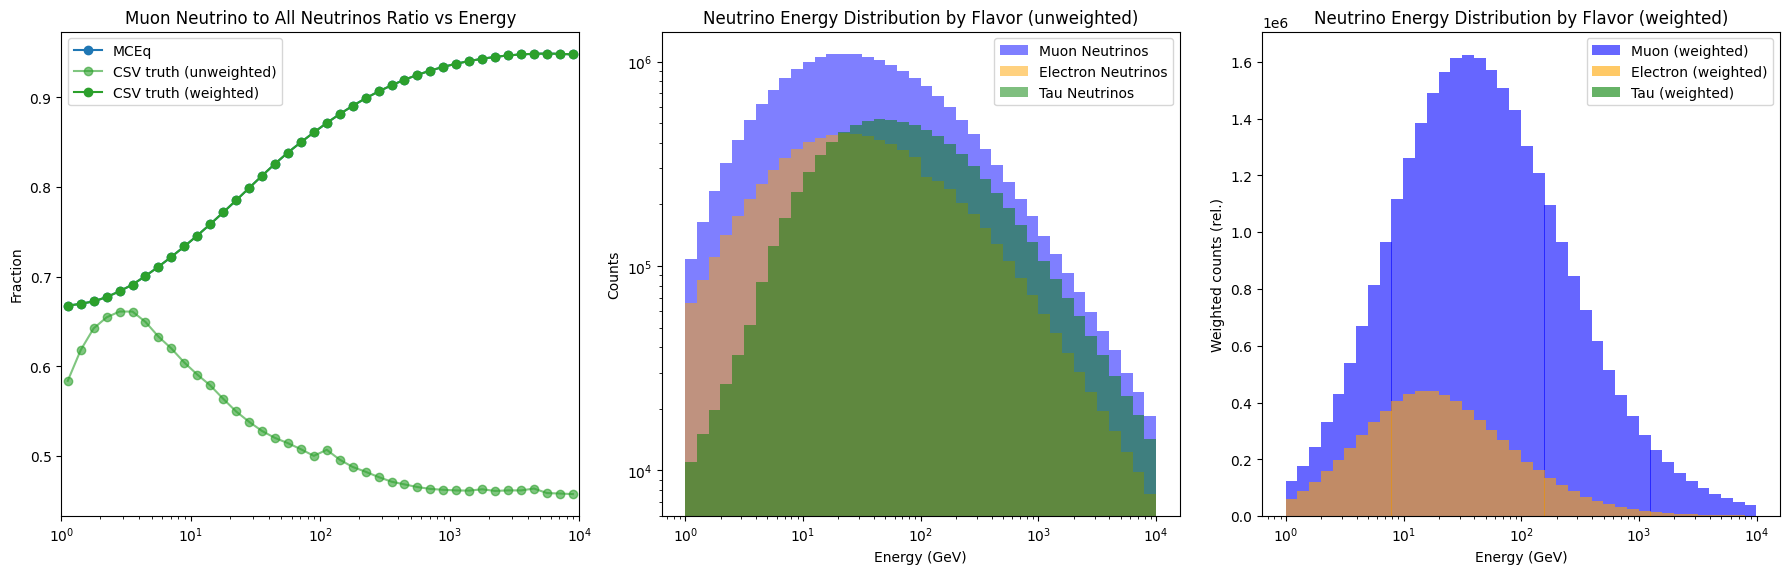

In [105]:
mu_to_all = flux['numu_total']/(flux['nue_total']+flux['numu_total']+flux['nutau_total'])

fig, ax = plt.subplots(1, 3, figsize=(18, 6))

# Left: muon fraction comparison
ax[0].plot(log_bincenters, mu_to_all, marker='o', label='MCEq', color='tab:blue')
ax[0].plot(log_bincenters, true_muon_to_total_list, marker='o', label='CSV truth (unweighted)', color='tab:green', alpha=0.6)
ax[0].plot(log_bincenters, true_muon_to_total_weighted_list, marker='o', label='CSV truth (weighted)', color='tab:green')
ax[0].set_ylabel('Fraction')
ax[0].set_title('Muon Neutrino to All Neutrinos Ratio vs Energy')
ax[0].set_xlim([1, 10000])
ax[0].set_xscale('log')
ax[0].legend()

# Middle: unweighted energy distributions
bins = np.logspace(np.log10(db_MC_neutrinos_cut['energy'].min()), np.log10(db_MC_neutrinos_cut['energy'].max()), 41)
ax[1].set_xscale('log')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 14]['energy'], bins=bins, alpha=0.5, label='Muon Neutrinos', color='blue')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 12]['energy'], bins=bins, alpha=0.5, label='Electron Neutrinos', color='orange')
ax[1].hist(db_MC_neutrinos_cut[abs(db_MC_neutrinos_cut['pid']) == 16]['energy'], bins=bins, alpha=0.5, label='Tau Neutrinos', color='green')
ax[1].set_xlabel('Energy (GeV)')
ax[1].set_yscale('log')
ax[1].set_ylabel('Counts')
ax[1].set_title('Neutrino Energy Distribution by Flavor (unweighted)')
ax[1].legend()

# Right: weighted per-flavor distributions (bar plot per bin)
# Compute per-bin widths from the precomputed bin edges; this yields one width per center
bin_widths = np.diff(log_binedges)
ax[2].bar(log_bincenters, mu_hist_w, width=bin_widths, alpha=0.6, label='Muon (weighted)', color='blue', align='center')
ax[2].bar(log_bincenters, e_hist_w,  width=bin_widths, alpha=0.6, label='Electron (weighted)', color='orange', align='center')
ax[2].bar(log_bincenters, tau_hist_w, width=bin_widths, alpha=0.6, label='Tau (weighted)', color='green', align='center')
ax[2].set_xscale('log')
ax[2].set_xlabel('Energy (GeV)')
ax[2].set_ylabel('Weighted counts (rel.)')
ax[2].set_title('Neutrino Energy Distribution by Flavor (weighted)')
ax[2].legend()

plt.tight_layout()
plt.show()

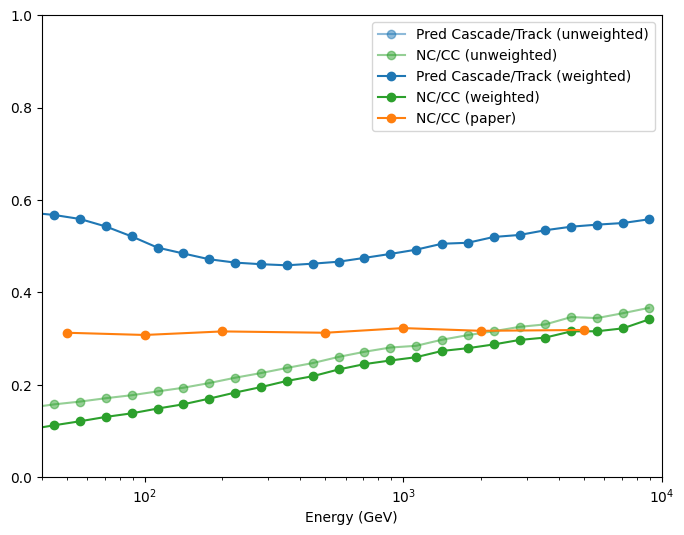

In [48]:
ratio = (np.array(NC_list))/(np.array(CC_list))
pred_ratio =   (np.array(casc_list))/np.array(track_list)

# Weighted ratios (safe div)
eps = 1e-12
ratio_w = (np.array(NC_w_list)) / (np.array(CC_w_list) + eps)
pred_ratio_w = (np.array(casc_pred_w_list)) / (np.array(track_pred_w_list) + eps)

sigma_cc = np.array([0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]) * 1e-36
sigma_nc = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36
energies_list = np.array([50, 100, 200, 500, 1000, 2000, 5000])  # GeV

true_ratio = sigma_nc / sigma_cc

fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(log_bincenters, pred_ratio, marker='o', label='Pred Cascade/Track (unweighted)', color='tab:blue', alpha=0.5)
ax.plot(log_bincenters, ratio, marker='o', label='NC/CC (unweighted)', color='tab:green', alpha=0.5)
ax.plot(log_bincenters, pred_ratio_w, marker='o', label='Pred Cascade/Track (weighted)', color='tab:blue')
ax.plot(log_bincenters, ratio_w, marker='o', label='NC/CC (weighted)', color='tab:green')
ax.plot(energies_list, true_ratio, marker='o', label='NC/CC (paper)', color='tab:orange')
ax.set_xlabel('Energy (GeV)')
ax.set_xscale('log')
ax.legend()

ax.set(xlim=(40, 10000), ylim=(0, 1))


plt.show()

In [ ]:

# Define quark list and their (I3, Q) values
_quarks = {
    'u': {'I3':  0.5, 'Q':  2/3},
    'c': {'I3':  0.5, 'Q':  2/3},
    'd': {'I3': -0.5, 'Q': -1/3},
    's': {'I3': -0.5, 'Q': -1/3},
    'b': {'I3': -0.5, 'Q': -1/3},
    # top quark not included (threshold very high, negligible PDF in nucleon at relevant x)
}

def gL_gR_for_quark(q, sin2w):
    """Return (gL, gR) for quark q given sin^2(theta_W)."""
    I3 = _quarks[q]['I3']
    Q  = _quarks[q]['Q']
    gL = I3 - Q * sin2w
    gR = - Q * sin2w
    return gL, gR

def coupling_squared_sum(sin2w):
    """
    Compute S(sin2w) = sum_q w_q * (gL^2 + gR^2)
    If weights is None, use equal weights for each quark in _quarks.
    weights should be a dict mapping quark->weight (nonnegative).
    """
    S = 0.0
    for q in _quarks.keys():
        gL, gR = gL_gR_for_quark(q, sin2w)
        S += (gL**2 + gR**2)
    return S

def R_of_sin2w(sin2w, sin2w_ref=0.23126):
    """
    Return scaling factor R(sin2w) = S(sin2w) / S(sin2w_ref)
    where S = sum_q w_q (gL^2 + gR^2).
    """
    S_ref = coupling_squared_sum(sin2w_ref)
    S = coupling_squared_sum(sin2w)
    return S / S_ref

def scale_sigma_NC(sigma_NC_ref, sin2w, sin2w_ref=0.2229):
    """
    Scale a reference sigma_NC (scalar or numpy array) by R(sin2w).
    Returns scaled sigma_NC for same shape as sigma_NC_ref.
    """
    R = R_of_sin2w(sin2w, sin2w_ref=sin2w_ref)
    return np.array(sigma_NC_ref) * float(R), float(R)

#0.2229 from standard model 1- (Mw)/(Mz)^2 

energies = np.array([50, 100, 200, 500, 1000, 2000, 5000])  # GeV

sigma_NC_ref = np.array([0.10, 0.20, 0.41, 1.0, 2.0, 3.8, 8.6]) * 1e-36  #from paper
sigma_CC_ref = np.array([0.32, 0.65, 1.3, 3.2, 6.2, 12, 27]) * 1e-36


# Compute scaling factors for a few sin2w choices
sin2w_values = [0.001, 0.01, 0.1, 0.23126, 0.3, 0.5, 0.7]
results = []

for s in sin2w_values:
    scaled_sigma, R = scale_sigma_NC(sigma_NC_ref, s)
    ratio = scaled_sigma / sigma_CC_ref
    results.append(ratio)

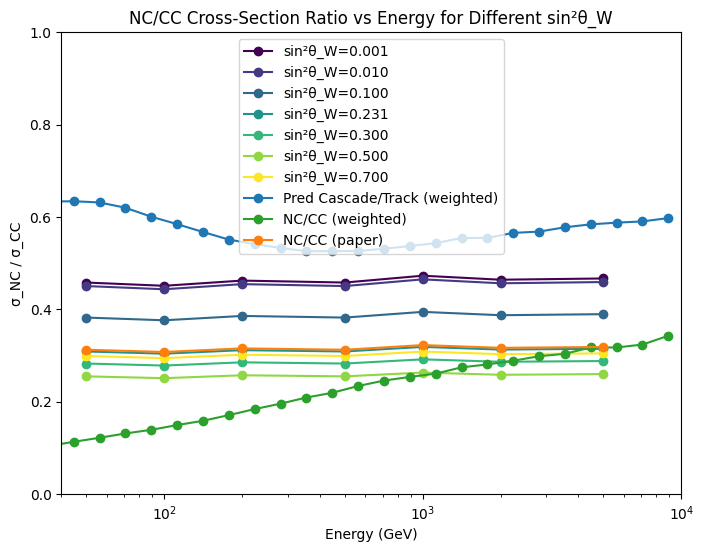

Assuming the cross section ratio is the same as the event ratio, best fit is basically 0. 
The weighted pred casc/track line only touches the sin2w lines if force_weights is False.


In [100]:

fig, ax = plt.subplots(figsize=(8, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(sin2w_values)))

for i, s in enumerate(sin2w_values):
    ax.plot(energies, results[i], marker='o', label=f'sin²θ_W={s:.3f}', color=colors[i])
ax.set_xscale('log')
ax.set_xlabel('Energy (GeV)')
ax.set_ylabel('σ_NC / σ_CC')
ax.set_title('NC/CC Cross-Section Ratio vs Energy for Different sin²θ_W')

ax.plot(log_bincenters, pred_ratio_w, marker='o', label='Pred Cascade/Track (weighted)', color='tab:blue')
ax.plot(log_bincenters, ratio_w, marker='o', label='NC/CC (weighted)', color='tab:green')
ax.plot(energies_list, true_ratio, marker='o', label='NC/CC (paper)', color='tab:orange')

ax.set_xlim(40, 10000)
ax.set_ylim(0, 1)
ax.legend()

plt.show()

print('Assuming the cross section ratio is the same as the event ratio, best fit is basically 0. \nThe weighted pred casc/track line only touches the sin2w lines if force_weights is False.')

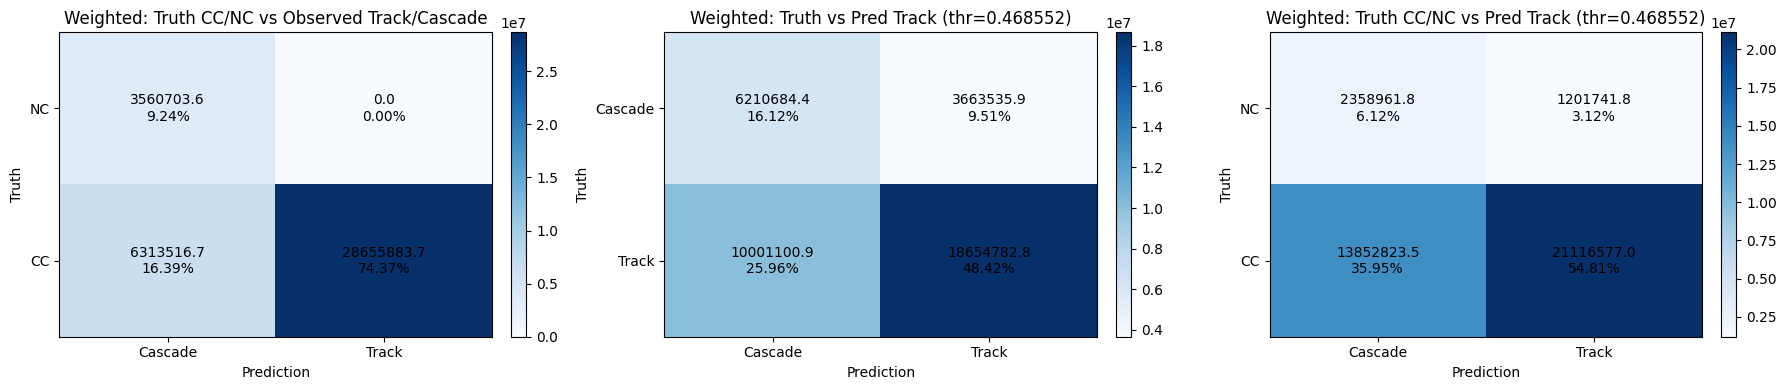

In [104]:
# Weighted confusion matrices using per-bin, per-flavor MCEq weights
# This mirrors the three unweighted confusion matrices but applies flavor composition weights.

# Threshold for predicted track/cascade

TN1_w = FP1_w = FN1_w = TP1_w = 0.0
TN2_w = FP2_w = FN2_w = TP2_w = 0.0
TN3_w = FP3_w = FN3_w = TP3_w = 0.0

for i in range(len(log_bincenters)):
    # Use precomputed ef

    db_in_bin = db_MC_neutrinos_cut[(db_MC_neutrinos_cut['energy'] > log_binedges[i]) & (db_MC_neutrinos_cut['energy'] <= log_binedges[i+1])]

    mu_mask = (abs(db_in_bin['pid']) == 14)
    e_mask   = (abs(db_in_bin['pid']) == 12)
    tau_mask = (abs(db_in_bin['pid']) == 16)

    # Reusable maw_mu_n = float(mu_w_list[i])
    w_e_n  = float(e_w_list[i])
    w_tau_n= float(tau_w_list[i])

    NC_bin = db_in_bin['interaction_type'] == 2
    CC_bin = db_in_bin['interaction_type'] == 1

    true_track = (db_in_bin['track_mu'] == 1)
    true_casc  = (db_in_bin['track_mu'] == 0)
    pred_track = (db_in_bin['track_mu_pred'] >= track_cut)
    pred_casc  = ~pred_track

    # 1) Truth CC/NC vs Observed Track/Cascade (track_mu as observed)
    # Matrix layout: rows [NC, CC], cols [Cascade, Track] -> [[TN, FP],[FN, TP]]
    TN1_w += (int((NC_bin & true_casc & mu_mask).sum()) * w_mu_n
              + int((NC_bin & true_casc & e_mask).sum())  * w_e_n
              + int((NC_bin & true_casc & tau_mask).sum())* w_tau_n)
    FP1_w += (int((NC_bin & true_track & mu_mask).sum()) * w_mu_n
              + int((NC_bin & true_track & e_mask).sum())  * w_e_n
              + int((NC_bin & true_track & tau_mask).sum())* w_tau_n)
    FN1_w += (int((CC_bin & true_casc & mu_mask).sum()) * w_mu_n
              + int((CC_bin & true_casc & e_mask).sum())  * w_e_n
              + int((CC_bin & true_casc & tau_mask).sum())* w_tau_n)
    TP1_w += (int((CC_bin & true_track & mu_mask).sum()) * w_mu_n
              + int((CC_bin & true_track & e_mask).sum())  * w_e_n
              + int((CC_bin & true_track & tau_mask).sum())* w_tau_n)

    # 2) Truth Track/Cascade vs Predicted Track/Cascade
    # Matrix layout: rows [Cascade, Track], cols [Cascade, Track] -> [[TN2, FP2],[FN2, TP2]]
    TN2_w += (int((pred_casc & true_casc & mu_mask).sum()) * w_mu_n
              + int((pred_casc & true_casc & e_mask).sum())  * w_e_n
              + int((pred_casc & true_casc & tau_mask).sum())* w_tau_n)
    FP2_w += (int((pred_track & true_casc & mu_mask).sum()) * w_mu_n
              + int((pred_track & true_casc & e_mask).sum())  * w_e_n
              + int((pred_track & true_casc & tau_mask).sum())* w_tau_n)
    FN2_w += (int((pred_casc & true_track & mu_mask).sum()) * w_mu_n
              + int((pred_casc & true_track & e_mask).sum())  * w_e_n
              + int((pred_casc & true_track & tau_mask).sum())* w_tau_n)
    TP2_w += (int((pred_track & true_track & mu_mask).sum()) * w_mu_n
              + int((pred_track & true_track & e_mask).sum())  * w_e_n
              + int((pred_track & true_track & tau_mask).sum())* w_tau_n)

    # 3) Truth CC/NC vs Predicted Track/Cascade
    # Matrix layout: rows [NC, CC], cols [Cascade, Track] -> [[TN3, FP3],[FN3, TP3]]
    TN3_w += (int((pred_casc & NC_bin & mu_mask).sum()) * w_mu_n
              + int((pred_casc & NC_bin & e_mask).sum())  * w_e_n
              + int((pred_casc & NC_bin & tau_mask).sum())* w_tau_n)
    FP3_w += (int((pred_track & NC_bin & mu_mask).sum()) * w_mu_n
              + int((pred_track & NC_bin & e_mask).sum())  * w_e_n
              + int((pred_track & NC_bin & tau_mask).sum())* w_tau_n)
    FN3_w += (int((pred_casc & CC_bin & mu_mask).sum()) * w_mu_n
              + int((pred_casc & CC_bin & e_mask).sum())  * w_e_n
              + int((pred_casc & CC_bin & tau_mask).sum())* w_tau_n)
    TP3_w += (int((pred_track & CC_bin & mu_mask).sum()) * w_mu_n
              + int((pred_track & CC_bin & e_mask).sum())  * w_e_n
              + int((pred_track & CC_bin & tau_mask).sum())* w_tau_n)

# Assemble weighted confusion matrices
cm1_w = np.array([[TN1_w, FP1_w], [FN1_w, TP1_w]], dtype=float)
cm2_w = np.array([[TN2_w, FP2_w], [FN2_w, TP2_w]], dtype=float)
cm3_w = np.array([[TN3_w, FP3_w], [FN3_w, TP3_w]], dtype=float)

# Plot weighted confusion matrices
fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# Left: CC/NC vs Cascade/Track (weighted)
im1 = axes[0].imshow(cm1_w, cmap='Blues', aspect='auto')
axes[0].set_xticks([0, 1])
axes[0].set_xticklabels(['Cascade', 'Track'])
axes[0].set_yticks([0, 1])
axes[0].set_yticklabels(['NC', 'CC'])
axes[0].set_xlabel('Prediction')
axes[0].set_ylabel('Truth')
for i in range(2):
    for j in range(2):
        count = cm1_w[i, j]
        pct = count / cm1_w.sum() if cm1_w.sum() else 0.0
        axes[0].text(j, i, f"{count:.1f}\n{pct:.2%}", ha='center', va='center', color='black')
axes[0].set_title('Weighted: Truth CC/NC vs Observed Track/Cascade')
plt.colorbar(im1, ax=axes[0], fraction=0.046, pad=0.04)

# Middle: track_mu (truth) vs track_mu_pred (weighted)
im2 = axes[1].imshow(cm2_w, cmap='Blues', aspect='auto')
axes[1].set_xticks([0, 1])
axes[1].set_xticklabels(['Cascade', 'Track'])
axes[1].set_yticks([0, 1])
axes[1].set_yticklabels(['Cascade', 'Track'])
axes[1].set_xlabel('Prediction')
axes[1].set_ylabel('Truth')
for i in range(2):
    for j in range(2):
        count = cm2_w[i, j]
        pct = count / cm2_w.sum() if cm2_w.sum() else 0.0
        axes[1].text(j, i, f"{count:.1f}\n{pct:.2%}", ha='center', va='center', color='black')
axes[1].set_title(f'Weighted: Truth vs Pred Track (thr={track_cut:g})')
plt.colorbar(im2, ax=axes[1], fraction=0.046, pad=0.04)

# Right: interaction_type (truth NC/CC) vs track_mu_pred (weighted)
im3 = axes[2].imshow(cm3_w, cmap='Blues', aspect='auto')
axes[2].set_xticks([0, 1])
axes[2].set_xticklabels(['Cascade', 'Track'])
axes[2].set_yticks([0, 1])
axes[2].set_yticklabels(['NC', 'CC'])
axes[2].set_xlabel('Prediction')
axes[2].set_ylabel('Truth')
for i in range(2):
    for j in range(2):
        count = cm3_w[i, j]
        pct = count / cm3_w.sum() if cm3_w.sum() else 0.0
        axes[2].text(j, i, f"{count:.1f}\n{pct:.2%}", ha='center', va='center', color='black')
axes[2].set_title(f'Weighted: Truth CC/NC vs Pred Track (thr={track_cut:g})')

plt.colorbar(im3, ax=axes[2], fraction=0.046, pad=0.04)
plt.tight_layout()
plt.show()